In [81]:
import os
import sys
import urllib, io

os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing

import importlib

In [82]:
## directory & file hierarchy
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli/interesting_structures')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [40]:
stim_dir

'/Users/will/GitHub/block_construction/stimuli/interesting_structures'

### Load Data

In [41]:
iterationName = 'pilot4'

In [42]:
# Trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
df = pd.read_csv(trial_path)

In [43]:
# Settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iterationName))
dfs = pd.read_csv(settled_path)

In [44]:
# Explore_end data
explore_path = os.path.join(csv_dir,'block_silhouette_explore_{}.csv'.format(iterationName))
dfe = pd.read_csv(explore_path)

In [45]:
# Exclude outliers
low_scores = df[(df.trialNum == 15) & (df.score == 0)]['gameID']

df = df[~df.gameID.isin(low_scores)]
dfs = dfs[~dfs.gameID.isin(low_scores)]
dfe = dfe[~dfe.gameID.isin(low_scores)]

n = df.gameID.nunique()
print(str(n) + ' participants with score > 0 and full set of trials')

32 participants with score > 0 and full set of trials


## Preprocessing

### Block Data

In [46]:
# add useful explore_end information to trial_end dataframe
df = df.merge(dfe[['gameID','trialNum','condition','totalExploreBlocks','numAttempts','finalExploreBlocks']], on=['gameID','trialNum','condition'], how='left')

## Explore Data

### Basic summaries

In [ ]:
physical_explore = dfe[dfe.condition == 'physical']

n_something = physical_explore[physical_explore.totalExploreBlocks > 0].shape[0]
n_nothing = physical_explore[physical_explore.totalExploreBlocks == 0].shape[0]

print('In ' + str(n_something) + ' physical explore phases, participant placed at least one block')
print('In ' + str(n_nothing) + ' physical explore phases, participant placed zero blocks')
print(str('{}% of physical exploration trials had one block placed in explore phase'\
          .format(100*n_something/(n_something+n_nothing))))

In [ ]:
# Number of blocks placed in each exploration phase for each participant
# For each participant

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.lineplot(data = physical_explore,
                palette='husl',
                hue='gameID',
                x='trialNum',
                y='totalExploreBlocks',
                alpha=0.3,
                legend=False)
plt.ylabel('PercentExploresUsed')
plt.xlabel('trialNum')
plt.tight_layout()
plt.title('blocks used in explore phase by participant', fontsize = 18)

### Filter out people who didn't consistently explore

In [ ]:
meanExploreBlocks = df.groupby(['gameID'])['totalExploreBlocks'].agg(np.mean)
goodPhysicalExplorers = meanExploreBlocks.reset_index()[meanExploreBlocks.reset_index().totalExploreBlocks>1].gameID

In [ ]:
# Number of blocks placed in each exploration phase for each good participant
# where 'good participant' means someone who placed an average of > 1 block per explore phase

dfeGoodPhysicalExplorers = dfe[dfe.gameID.isin(goodPhysicalExplorers)]
physical_explore_good = dfeGoodPhysicalExplorers[dfeGoodPhysicalExplorers.condition == 'physical']

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.lineplot(data = physical_explore_good,
                palette='husl',
                hue='gameID',
                x='trialNum',
                y='totalExploreBlocks',
                alpha=0.3,
                legend=False)
plt.ylabel('PercentExploresUsed')
plt.xlabel('trialNum')
plt.tight_layout()
plt.title('blocks used in explore phase by participant', fontsize = 18)

In [ ]:
dfGoodPhysicalExplorers = df[df.gameID.isin(goodPhysicalExplorers)]

#df['activeExplorer'] = False
#df[df.gameID.isin(goodPhysicalExplorers)]['activeExplorer'] = True

fig = plt.figure(figsize=(6,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=dfGoodPhysicalExplorers,
                palette='husl',
                x='condition',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0,1,6))
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(6,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=df,
                palette='husl',
                x='condition',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0,1,6))
plt.tight_layout()

## Look at structures that people created

### Render all final structures- rows are participants, columns are structures

In [122]:
importlib.reload(drawing) 

<module 'drawing_utils' from '/Users/will/GitHub/block_construction/analysis/will/drawing_utils.py'>

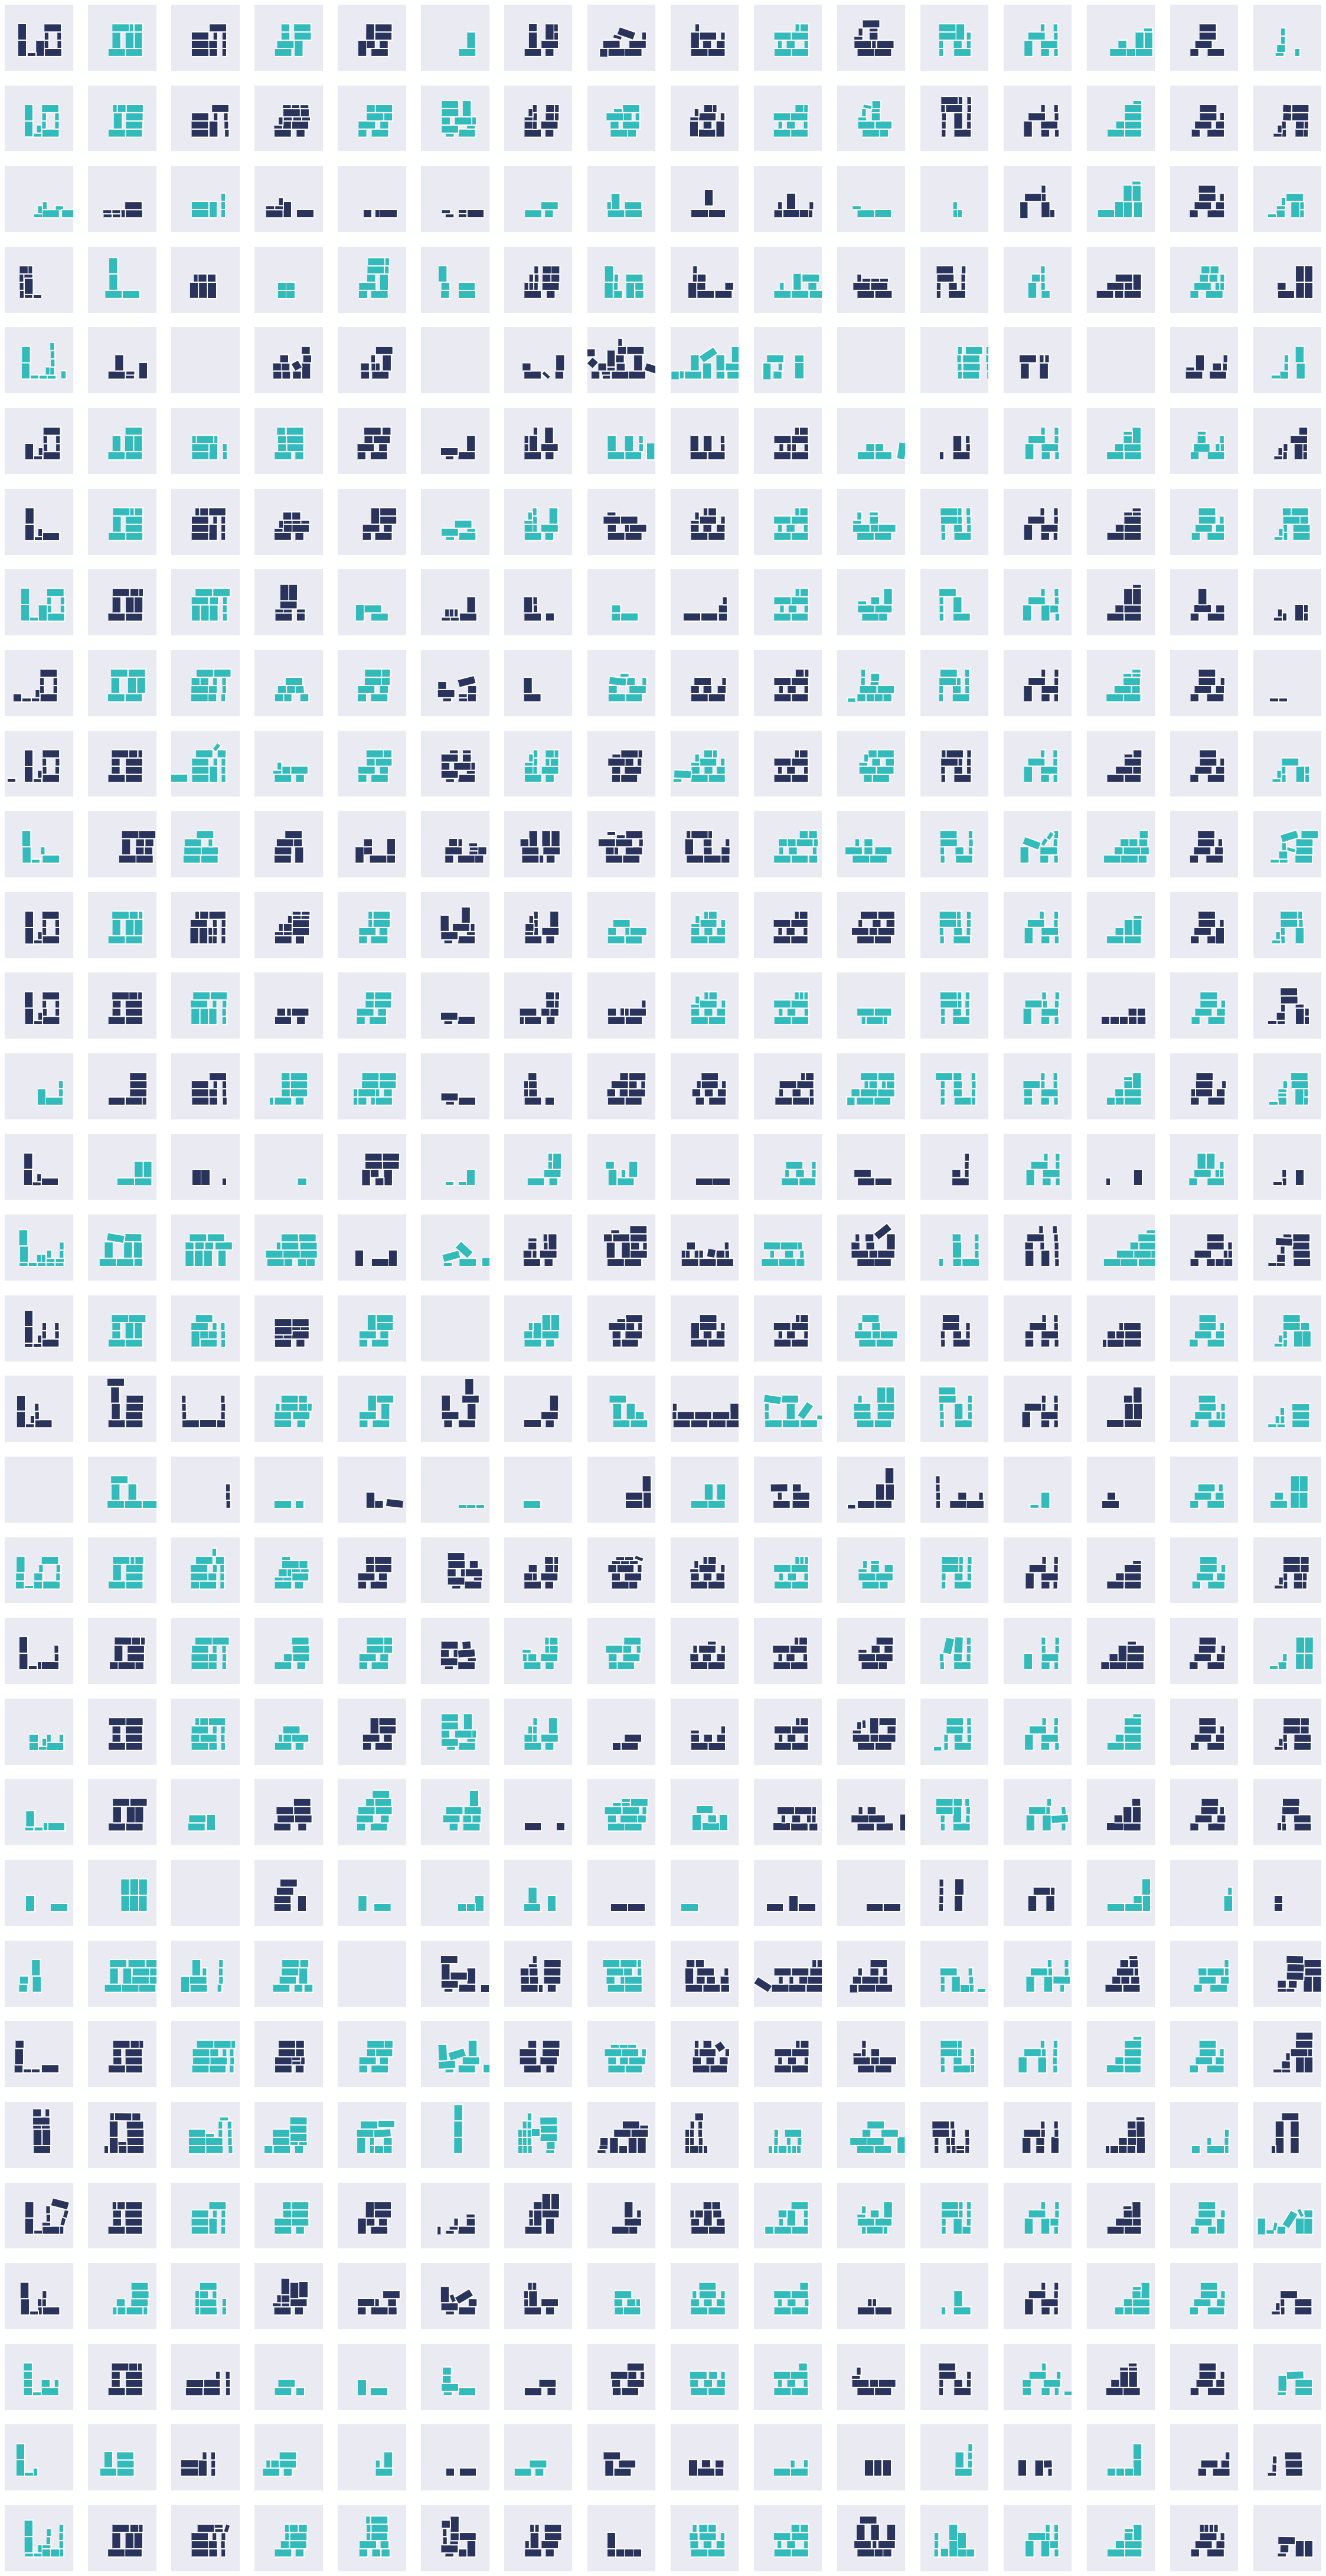

In [117]:
drawing.draw_all_final_structures(df)

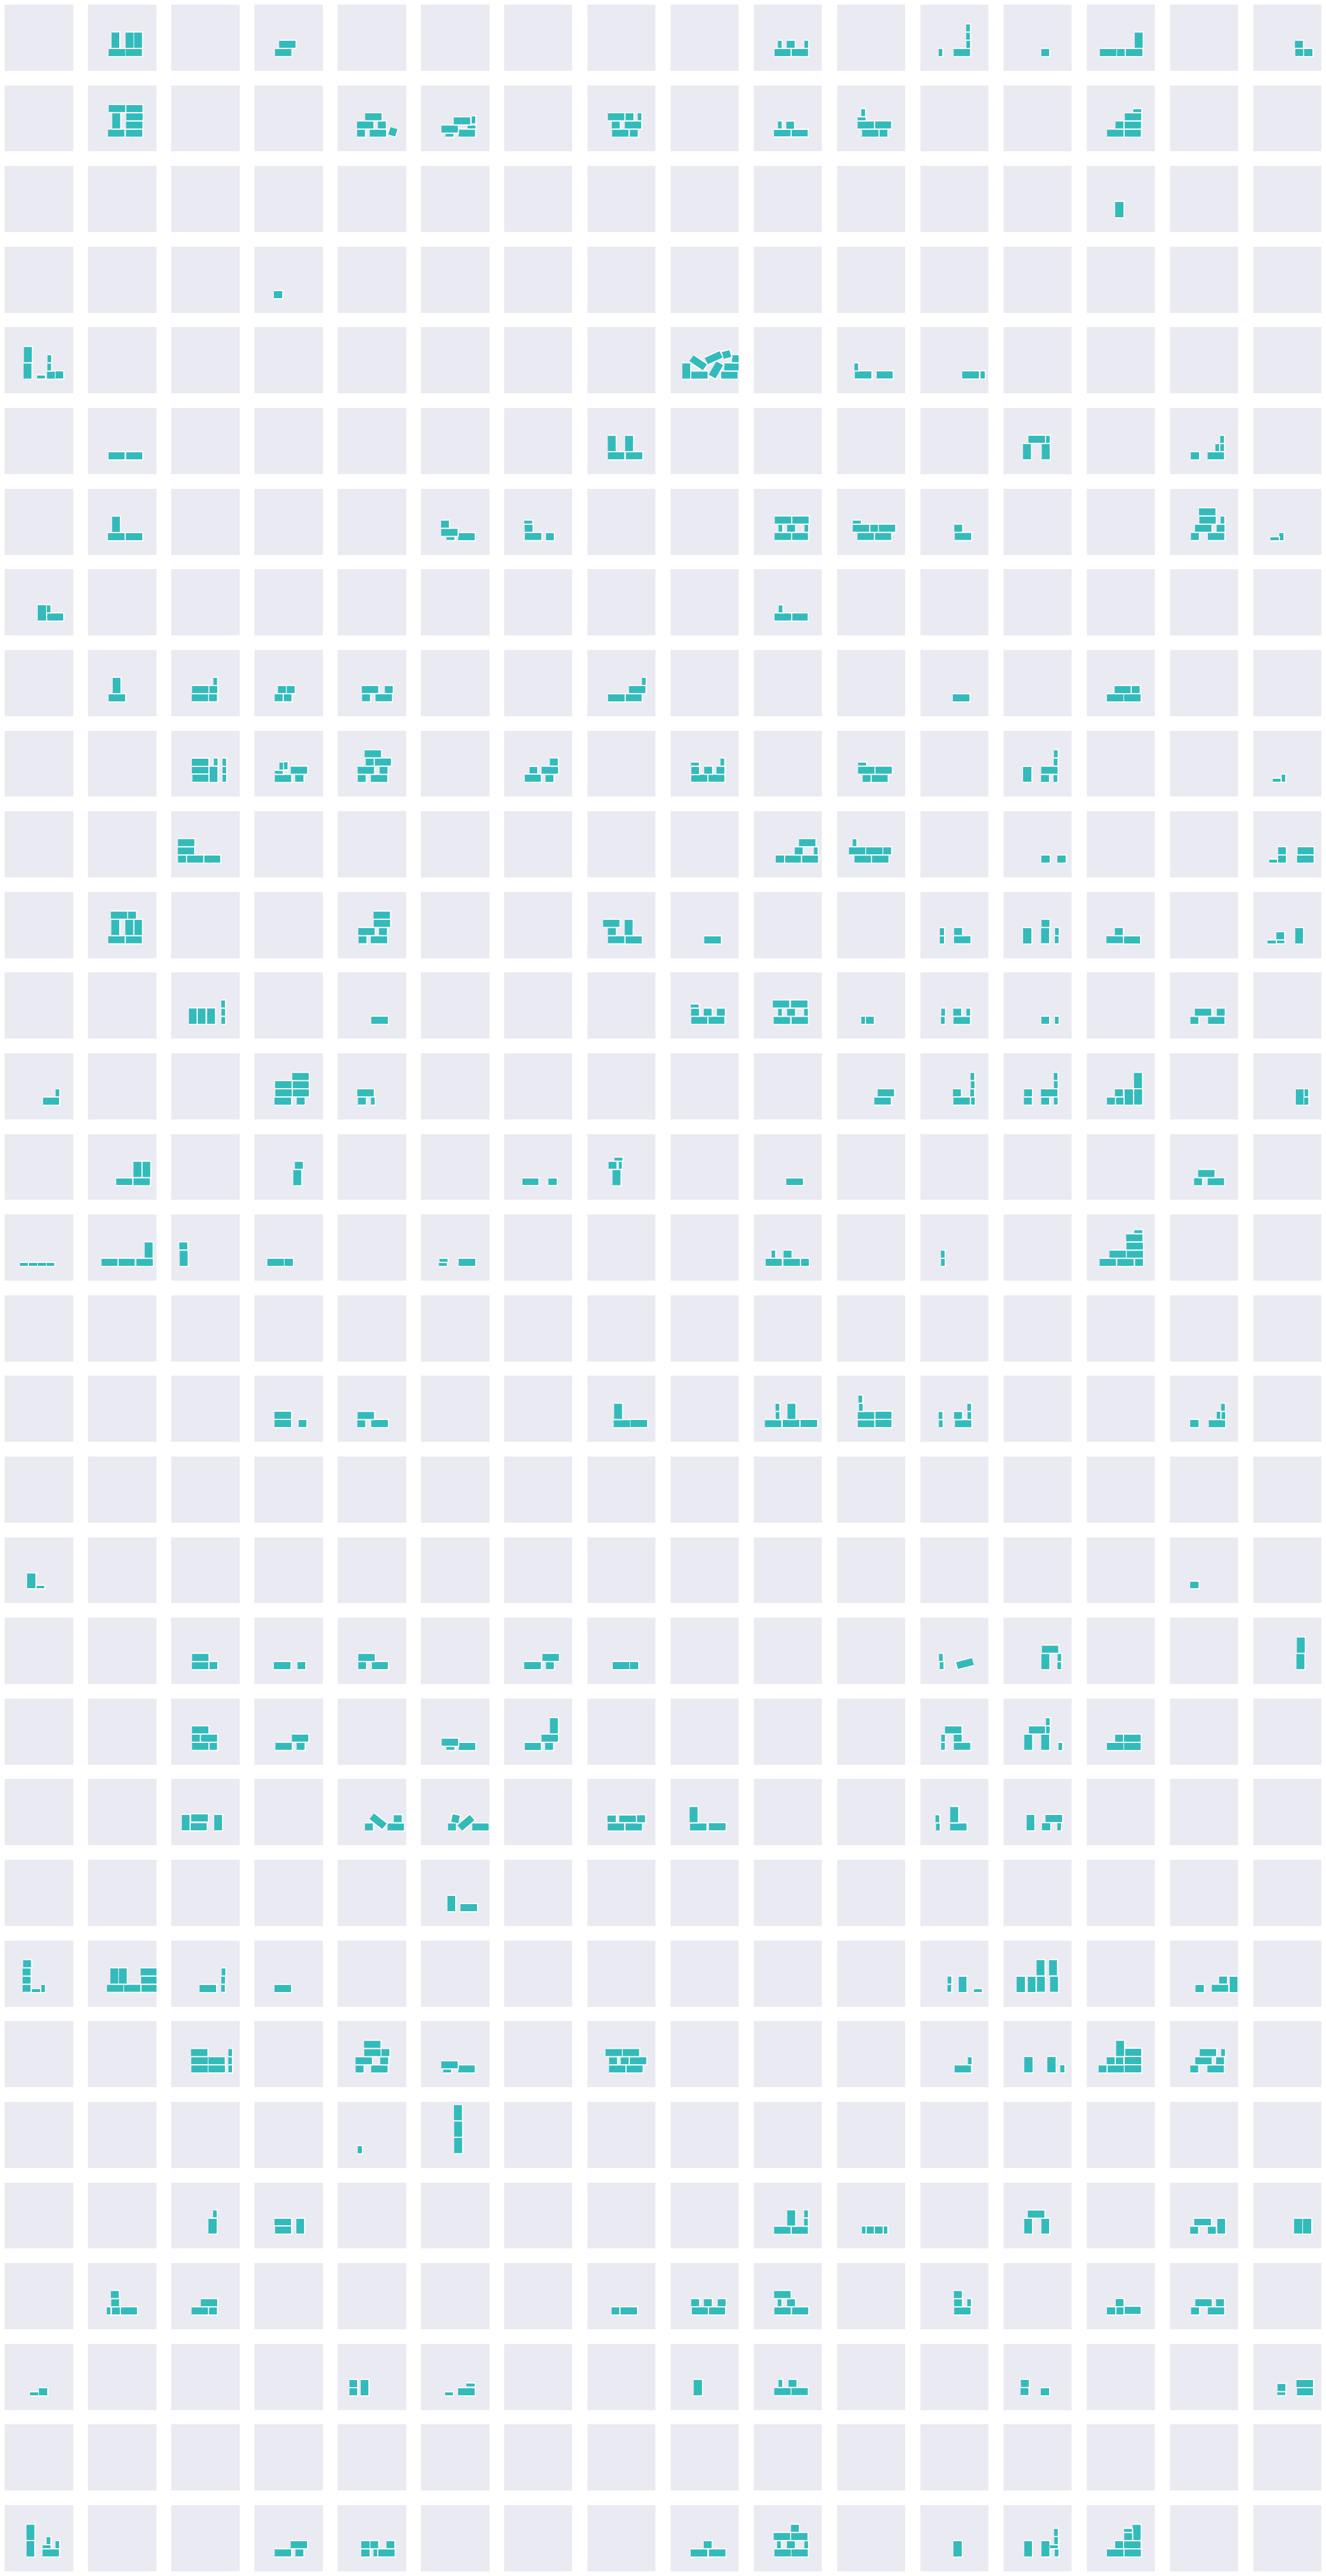

In [118]:
drawing.draw_all_final_structures(dfe)

<Figure size 1440x1440 with 0 Axes>

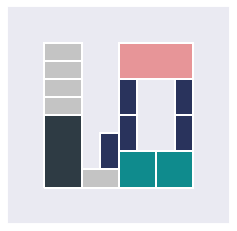

In [115]:
drawing.draw_stim_from_json('hand_selected_001', stim_dir)

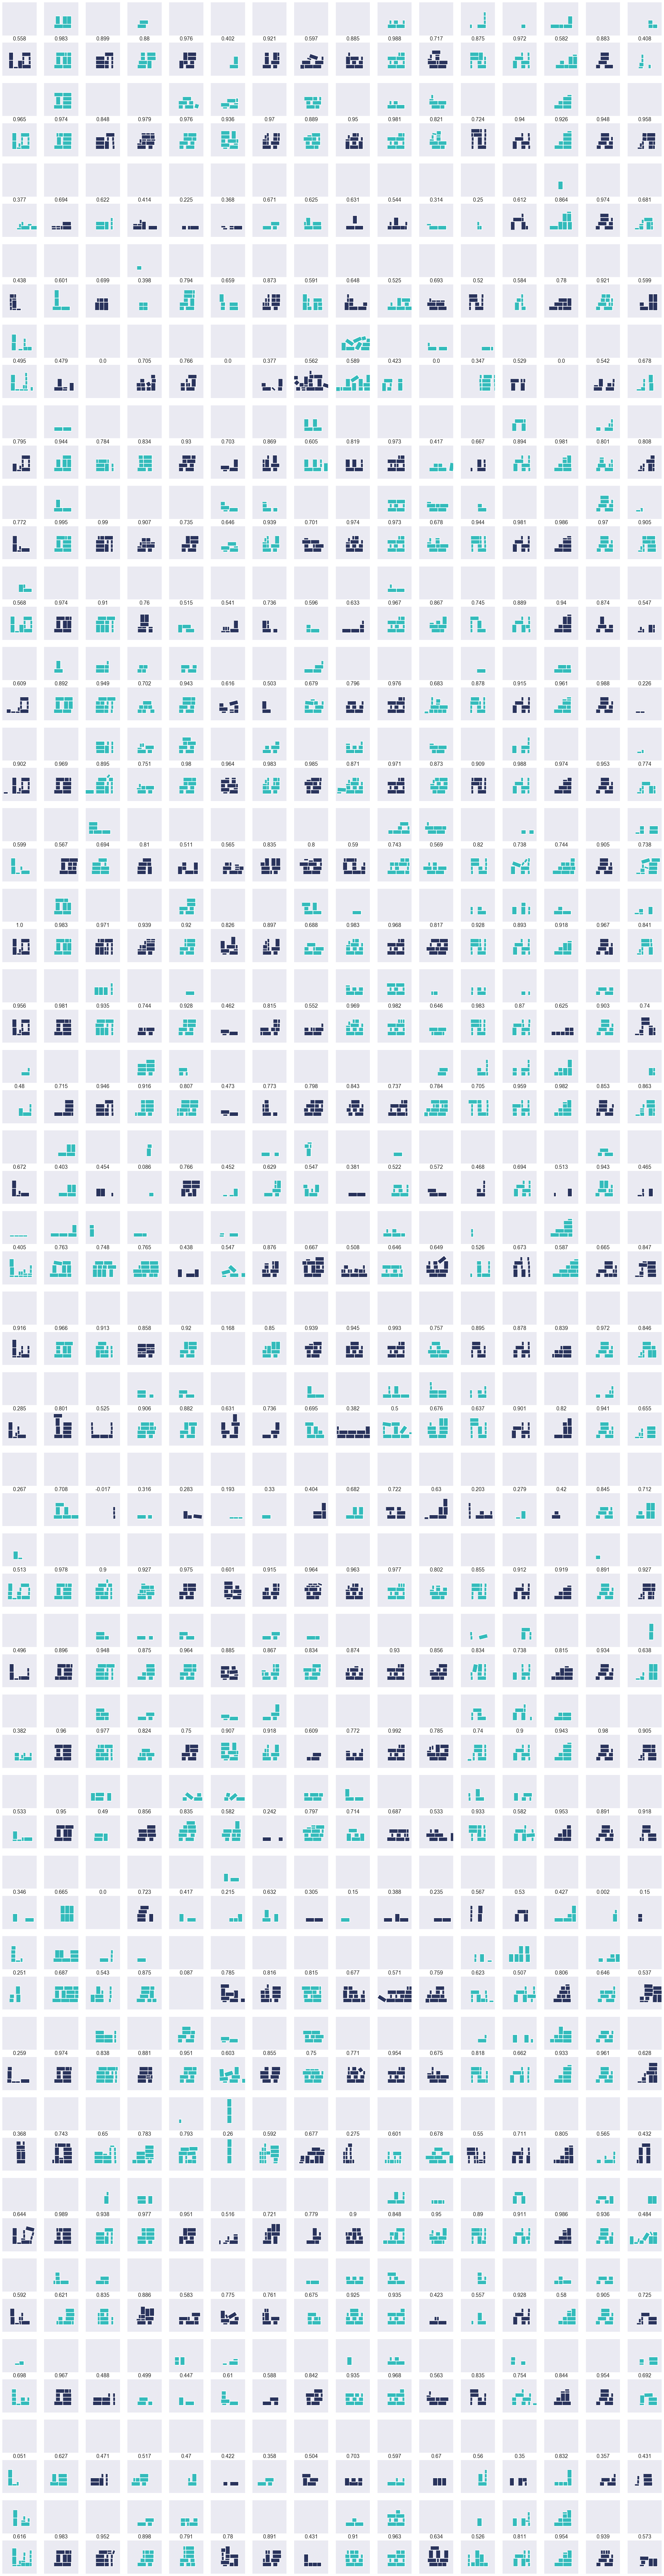

In [140]:
importlib.reload(drawing)
drawing.draw_all_final_structures_and_explores(df,dfe)

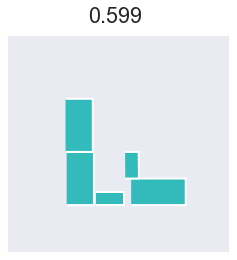

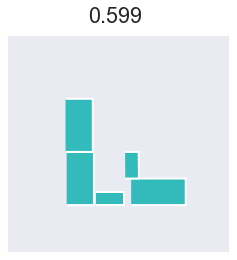

In [133]:
drawing.draw_final_structure(df, df.gameID.unique()[10], df.targetName.unique()[3])

In [134]:
importlib.reload(drawing)

<module 'drawing_utils' from '/Users/will/GitHub/block_construction/analysis/will/drawing_utils.py'>